# Import Library

In [1]:
!pip uninstall -y tensorflow

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0


In [2]:
import torch
import torch.nn as nn
torch.autograd.set_detect_anomaly(True)

print('pytorch version:', torch.__version__)
print("GPU available:", torch.cuda.device_count())
#print('GPU name:',torch.cuda.get_device_name(0))
device_name = (torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu")
print("device name:", device_name)

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

pytorch version: 2.5.1+cu124
GPU available: 0
device name: cpu
device: cpu


In [3]:
# For data augmentation
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import v2
import torchvision.models as models

In [74]:
from torchsummary import summary

In [4]:
import transformers

# For Tokenizers
from transformers import ViTImageProcessor, ViTConfig

# For Model
from transformers import ViTModel, ViTForImageClassification

# For TPU
from transformers import set_seed
from torch.optim import AdamW

In [5]:
#!pip install -q datasets #==2.10.0

In [6]:
# For Data Loaders
#import datasets
from torch.utils.data import Dataset, DataLoader
#from torchvision.transforms import Compose, Resize, ToTensor

In [7]:
# For Display
from tqdm.notebook import tqdm

# For GPU
from accelerate import Accelerator, notebook_launcher

In [8]:
#!pip install -q decord

In [9]:
## Use PyTorch bridge for Decord
#import decord
#
#from decord.bridge import set_bridge
#decord.bridge.set_bridge("torch")
#
#from decord import VideoReader

In [10]:
!pip install -q kaggle

In [11]:
import kagglehub
import random

import cv2
from google.colab.patches import cv2_imshow

import os
import zipfile

from PIL import Image
import gc
from glob import glob
import shutil
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,5]
from itertools import combinations, product

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [13]:
import torch.nn.functional as F
from torch.nn import CosineEmbeddingLoss

In [14]:
import timm

In [15]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Initialse Globle Variables

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
from google.colab import userdata
secret_token_hf = userdata.get('HF_TOKEN')

In [18]:
gdrive_path = '/content/drive/MyDrive/Kaggle/FaceRecognition'
local_path = '/content/FaceRecognition'

In [139]:
BATCH_SIZE = 8
print('BATCH_SIZE =',BATCH_SIZE)

MODEL_TRANSFORMER = 'google/vit-base-patch16-224'
MODEL = "IMAGENET1K_V1"

#EMBEDDING_SIZE = 128 #512
#print('CLIP_LENGTH =',EMBEDDING_SIZE)

CLIP_SIZE = 224
print('Image Dimension =', CLIP_SIZE,'X', CLIP_SIZE)

BATCH_SIZE = 8
Image Dimension = 224 X 224


In [20]:
#import os
#os.environ["CUDA_MODULE_LOADING"] = "LAZY"

In [21]:
def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [22]:
seed_everything(42)

# Import Data

In [23]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle/.kaggle'

In [24]:
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [00:47<00:00, 32.6MB/s]
100% 1.33G/1.33G [00:47<00:00, 30.3MB/s]


In [25]:
# Create a directory for the dataset
dataset_path = "/content/celeba_dataset"
os.makedirs(dataset_path, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile("celeba-dataset.zip", "r") as zip_ref:
    zip_ref.extractall(dataset_path)

In [26]:
#!cp -r /content/drive/MyDrive/Kaggle/FaceRecognition/celebA/list_bbox_celeba.txt /content/celeba_dataset
#!cp -r /content/drive/MyDrive/Kaggle/FaceRecognition/celebA/list_attr_celeba.txt /content/celeba_dataset
!cp -r /content/drive/MyDrive/Kaggle/FaceRecognition/celebA/list_identity_celeba.txt /content/celeba_dataset
#!cp -r /content/drive/MyDrive/Kaggle/FaceRecognition/celebA/list_landmarks_celeba.txt /content/celeba_dataset

In [27]:
print(os.listdir(f"{dataset_path}"))

['list_attr_celeba.csv', 'img_align_celeba', 'list_eval_partition.csv', 'list_identity_celeba.txt', 'list_landmarks_align_celeba.csv', 'list_bbox_celeba.csv']


In [28]:
identity_df = pd.read_csv(f"{dataset_path}/list_identity_celeba.txt", sep='\s+', header=None, names=["image", "identity"])
identity_df.head()

,image,identity
0,000001.jpg,2880
1,000002.jpg,2937
2,000003.jpg,8692
3,000004.jpg,5805
4,000005.jpg,9295


In [29]:
partition_df = pd.read_csv(f"{dataset_path}/list_eval_partition.csv", header=0, names=["image", "partition"])
partition_df.head()

,image,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [30]:
landmarks_df = pd.read_csv(f"{dataset_path}/list_landmarks_align_celeba.csv", header=0)
landmarks_df.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


In [31]:
attribute_df = pd.read_csv(f"{dataset_path}/list_attr_celeba.csv", header=0)
attribute_df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [32]:
bbox_df = pd.read_csv(f"{dataset_path}/list_bbox_celeba.csv", header=0)
bbox_df.head()

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166


In [33]:
bbox_df.x_1[bbox_df.image_id == '000001.jpg'].item()

95

# Select desired data

In [34]:
identity_df.identity.max()

10177

In [35]:
identity_small_df = identity_df[identity_df['identity'] < 1500].copy()
identity_small_df.head()

,image,identity
9,000010.jpg,612
16,000017.jpg,667
20,000021.jpg,181
22,000023.jpg,1
31,000032.jpg,268


In [36]:
identity_small_df.shape

(31724, 2)

In [37]:
partition_df['partition'].value_counts()

,count
partition,
0,162770
2,19962
1,19867


In [38]:
combined_df = pd.concat([identity_df.set_index(keys=['image'], verify_integrity=True), partition_df.set_index(keys=['image'], verify_integrity=True)], axis=1, verify_integrity=True).copy()

In [39]:
combined_df['partition'].value_counts()

,count
partition,
0,162770
2,19962
1,19867


In [40]:
combined_df.shape

(202599, 2)

In [41]:
combined_small_df = pd.concat([identity_small_df.set_index(keys=['image'], verify_integrity=True), partition_df.set_index(keys=['image'], verify_integrity=True)], axis=1, join='inner',verify_integrity=True).copy()

In [42]:
combined_small_df.shape

(31724, 2)

In [43]:
train_df = combined_df[combined_df['partition']==0].copy()
val_df = combined_df[combined_df['partition']==1].copy()
test_df = combined_df[combined_df['partition']==2].copy()

In [44]:
train_df.head()

,identity,partition
image,,
000001.jpg,2880,0
000002.jpg,2937,0
000003.jpg,8692,0
000004.jpg,5805,0
000005.jpg,9295,0


In [45]:
train_df.shape

(162770, 2)

In [46]:
temp_1 = list(train_df['identity'].unique())
print(temp_1[:10])
temp_2 = temp_1[2]
temp_1.remove(temp_2)
print(temp_1[:10])

[2880, 2937, 8692, 5805, 9295, 4153, 9040, 6369, 3332, 612]
[2880, 2937, 5805, 9295, 4153, 9040, 6369, 3332, 612, 2807]


In [47]:
temp_1[:10]

[2880, 2937, 5805, 9295, 4153, 9040, 6369, 3332, 612, 2807]

# Create Dataset



In [48]:
def createContrastPairs(data_df):
  selected_list = []
  negetive_list = []
  classes = list(data_df['identity'].unique())
  for cls1 in tqdm(classes):
    # randomly select alternate class
    temp_cls = classes
    temp_cls.remove(cls1)
    cls2 = random.choice(temp_cls)

    # List all the
    images_class1 = data_df[data_df['identity'] == cls1].index.to_list()
    images_class2 = data_df[data_df['identity'] == cls2].index.to_list()

    # Create list of all positive combinations
    for img1, img2 in combinations(images_class1, 2):
      selected_list.append([img1, img2, 1])

    # Create list of negetive combinations
    for img1, img2 in product(images_class1, images_class2):
      negetive_list.append([img1, img2, -1])

  # Balance the positive and negetive list
  negetive_list = random.sample(negetive_list, len(selected_list))
  # Combine the selections
  selected_list.extend(negetive_list)

  # Create Dataframe
  data_df = pd.DataFrame(selected_list, columns=['image1','image2','similarity'])
  # Shuffle dataset
  data_df = data_df.sample(frac = 1)

  return data_df

In [49]:
CLASSES = train_df.identity.max()
print('total number of classes',CLASSES)
root_dir = f"{dataset_path}/img_align_celeba/img_align_celeba"
print('root directory',root_dir)

total number of classes 10177
root directory /content/celeba_dataset/img_align_celeba/img_align_celeba


In [50]:
#image_processor = ViTImageProcessor.from_pretrained(MODEL_TRANSFORMER, attn_implementation="sdpa", torch_dtype=torch.float16)

In [51]:
class CustomDataset(Dataset):
    def __init__(self, image_num_1, image_num_2, labels):
        self.image_num_1 = image_num_1  # Store paths instead of images
        self.image_num_2 = image_num_2
        self.labels = labels
        self.transform_dataset = ViTImageProcessor.from_pretrained(MODEL_TRANSFORMER, attn_implementation="sdpa", torch_dtype=torch.float16)

    def __len__(self):
        return len(self.image_num_1)

    def __getitem__(self, idx):
        img_path_1 = self.image_num_1[idx]
        img_path_2 = self.image_num_2[idx]

         # Load image 1 when needed
        image_1 = Image.open(img_path_1).convert("RGB")
        image_1 = self.transform_dataset(image_1)['pixel_values'][0]

         # Load image 2 when needed
        image_2 = Image.open(img_path_2).convert("RGB")
        image_2 = self.transform_dataset(image_2)['pixel_values'][0]

        label = self.labels[idx]

        return {'pixel_values_1': image_1, 'pixel_values_2': image_2, 'labels': label}

In [52]:
train_pair_df = createContrastPairs(train_df)
val_pair_df = createContrastPairs(val_df)
test_pair_df = createContrastPairs(test_df)

  0%|          | 0/8192 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [53]:
train_len = 1000
train_df_select = train_pair_df.sample(train_len)
val_df_select = val_pair_df.sample(train_len)
test_df_select = test_pair_df.sample(train_len)

In [54]:
#train_df = combined_df[combined_df['partition']==0].copy()
train_ds = CustomDataset(
        image_num_1=[os.path.join(root_dir, img) for img in train_df_select.image1.to_list()],
        image_num_2=[os.path.join(root_dir, img) for img in train_df_select.image2.to_list()],
        labels=torch.tensor(train_df_select.similarity.values, dtype=torch.int64)
        )
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [55]:
#val_df = combined_df[combined_df['partition']==1].copy()

val_ds = CustomDataset(
        image_num_1=[os.path.join(root_dir, img) for img in val_df_select.image1.to_list()],
        image_num_2=[os.path.join(root_dir, img) for img in val_df_select.image2.to_list()],
        labels=torch.tensor(val_df_select.similarity.values, dtype=torch.int64)
        )
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

In [56]:
#test_df = combined_df[combined_df['partition']==2].copy()
test_ds = CustomDataset(
        image_num_1=[os.path.join(root_dir, img) for img in test_df_select.image1.to_list()],
        image_num_2=[os.path.join(root_dir, img) for img in test_df_select.image2.to_list()],
        labels=torch.tensor(test_df_select.similarity.values, dtype=torch.int64)
        )
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

# Testing Dataloader

In [57]:
#train_ds = dataset_obj.create_dataset(identity_df=combined_df[combined_df['partition']==0][:50])
#train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

In [58]:
# Convert images to numpy for visualization
def imgshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

torch.Size([8, 3, 224, 224]) torch.Size([8, 3, 224, 224]) torch.Size([8])


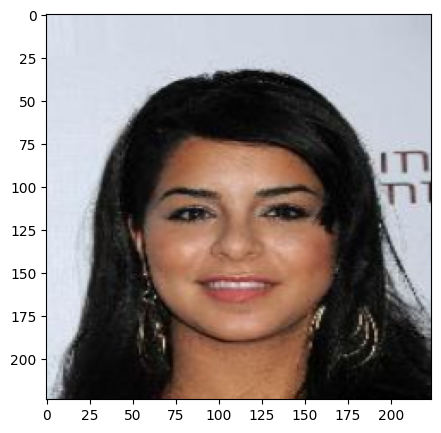

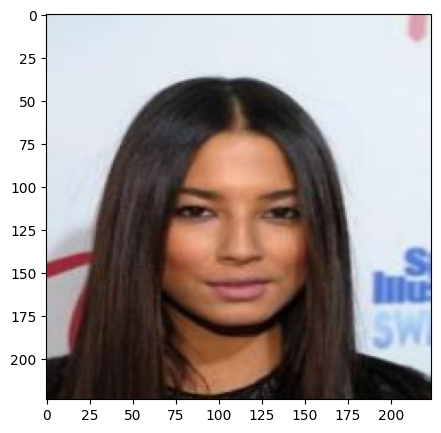

tensor(-1)


In [59]:
# Testing the dataset
batch = next(iter(train_dl))
print(batch['pixel_values_1'].shape,batch['pixel_values_1'].shape, batch['labels'].shape)
imgshow(torchvision.utils.make_grid(batch['pixel_values_1'][0]))
imgshow(torchvision.utils.make_grid(batch['pixel_values_2'][0]))
print(batch['labels'][0])

In [60]:
batch

{'pixel_values_1': tensor([[[[ 0.7020,  0.7255,  0.7255,  ...,  0.4902,  0.4902,  0.4902],
           [ 0.7020,  0.7255,  0.7255,  ...,  0.4902,  0.4902,  0.4902],
           [ 0.7020,  0.7255,  0.7176,  ...,  0.4902,  0.4902,  0.4902],
           ...,
           [ 0.7412,  0.6392,  0.3804,  ..., -0.9216, -0.8588, -0.8510],
           [ 0.6392,  0.5686,  0.5686,  ..., -0.9686, -0.9608, -0.9529],
           [ 0.5843,  0.5059,  0.4980,  ..., -0.9686, -0.9608, -0.9529]],
 
          [[ 0.7490,  0.7725,  0.7725,  ...,  0.5373,  0.5373,  0.5373],
           [ 0.7490,  0.7725,  0.7725,  ...,  0.5373,  0.5373,  0.5373],
           [ 0.7490,  0.7725,  0.7647,  ...,  0.5373,  0.5373,  0.5373],
           ...,
           [ 0.8275,  0.7255,  0.4588,  ..., -0.9216, -0.8588, -0.8510],
           [ 0.7255,  0.6549,  0.6471,  ..., -0.9686, -0.9608, -0.9529],
           [ 0.6706,  0.5922,  0.5765,  ..., -0.9686, -0.9608, -0.9529]],
 
          [[ 0.8431,  0.8667,  0.8667,  ...,  0.6314,  0.6314,  0.63

In [61]:
batch['pixel_values_1'][0]

tensor([[[ 0.7020,  0.7255,  0.7255,  ...,  0.4902,  0.4902,  0.4902],
         [ 0.7020,  0.7255,  0.7255,  ...,  0.4902,  0.4902,  0.4902],
         [ 0.7020,  0.7255,  0.7176,  ...,  0.4902,  0.4902,  0.4902],
         ...,
         [ 0.7412,  0.6392,  0.3804,  ..., -0.9216, -0.8588, -0.8510],
         [ 0.6392,  0.5686,  0.5686,  ..., -0.9686, -0.9608, -0.9529],
         [ 0.5843,  0.5059,  0.4980,  ..., -0.9686, -0.9608, -0.9529]],

        [[ 0.7490,  0.7725,  0.7725,  ...,  0.5373,  0.5373,  0.5373],
         [ 0.7490,  0.7725,  0.7725,  ...,  0.5373,  0.5373,  0.5373],
         [ 0.7490,  0.7725,  0.7647,  ...,  0.5373,  0.5373,  0.5373],
         ...,
         [ 0.8275,  0.7255,  0.4588,  ..., -0.9216, -0.8588, -0.8510],
         [ 0.7255,  0.6549,  0.6471,  ..., -0.9686, -0.9608, -0.9529],
         [ 0.6706,  0.5922,  0.5765,  ..., -0.9686, -0.9608, -0.9529]],

        [[ 0.8431,  0.8667,  0.8667,  ...,  0.6314,  0.6314,  0.6314],
         [ 0.8431,  0.8667,  0.8667,  ...,  0

# Model Selection

In [62]:
torch.cuda.empty_cache()

In [112]:
# Load EfficientNet with pre-trained weights
temp_efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

In [80]:
#temp_efficientnet.parameters()

In [81]:
# Print architecture
#print(temp_efficientnet)

In [113]:
summary(temp_efficientnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [114]:
# Freeze all layers initially
for param in temp_efficientnet.parameters():
    param.requires_grad = False

In [115]:
summary(temp_efficientnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [122]:
temp_efficientnet_backbone = list(temp_efficientnet.children())[0]  # Remove classifier by selecting only the backbone

In [123]:
summary(temp_efficientnet_backbone, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [126]:
temp_efficientnet_backbone[-1]

Conv2dNormActivation(
  (0): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
)

In [127]:
for param in temp_efficientnet_backbone[-1].parameters():
    param.requires_grad = True  # Only train last two blocks

In [128]:
summary(temp_efficientnet_backbone, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

# Model Building

In [140]:
torch.cuda.empty_cache()

In [142]:
hyperparameters = {
    "learning_rate": 0.0001,
    "num_epochs": 1000, # set to very high number
    "seed": 42,
    "patience": 10, # early stopping
    "output_dir_pt": f"{gdrive_path}/EfficientNet_B0_celebA_imagenetWTS_1.pt",
    #'dropout_rate': 0.2,
    #'num_dense_layers': 6,
    #'hidden_dim': 16
}


In [143]:
class EfficientNetEmbedding(nn.Module):
    def __init__(self, model_name="DEFAULT"):
        super().__init__()
        self.model_name = model_name
        # Load pre-trained EfficientNet
        self.base_model = models.efficientnet_b0(weights=self.model_name) # models.EfficientNet_B0_Weights.DEFAULT

        # Freeze all layers initially
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove classifier by selecting only the backbone
        self.base_model_backbone = list(self.base_model.children())[0]

        # Unfreeze only the last one blocks
        for param in self.base_model_backbone[-1].parameters():
            param.requires_grad = True  # Only train last one blocks

    def forward(self, x):
        x = self.base_model_backbone(x)  # Feature extraction
        x = torch.flatten(x, start_dim=1)  # Flatten output to 1D embeddings
        return x  # Return as embeddings

In [144]:
# Now we train the model
def training_function():
    # Initialize accelerator
    accelerator = Accelerator()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # Instantiate the model, chnage the final classification layer, let Accelerate handle the device placement.
    embedding_model = EfficientNetEmbedding(model_name=MODEL)

    # Loss function
    criterion = CosineEmbeddingLoss(margin=0.25)

    # Filter parameters to include only the ones that require gradients
    trainable_params = [p for p in embedding_model.parameters() if p.requires_grad]

    # Instantiate the AdamW optimizer for only trainable parameters
    optimizer = AdamW(trainable_params, lr=hyperparameters["learning_rate"])

    # Define the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True, min_lr=0.00001
    )

    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    accelerated_model, acclerated_criterion ,acclerated_optimizer, acclerated_train_dl, acclerated_val_dl = accelerator.prepare(embedding_model, criterion, optimizer, train_dl, val_dl)

    # Build the training loop
    epochs_no_improve = 0
    min_val_loss = float("inf")

    for epoch in range(hyperparameters["num_epochs"]):
      # We only enable the progress bar on the main process to avoid having 8 progress bars.
      progress_bar = tqdm(range(len(acclerated_train_dl)), disable=not accelerator.is_main_process)
      progress_bar.set_description(f"Epoch: {epoch}")
      accelerated_model.train()
      training_loss = []
      for batch in acclerated_train_dl:
          # Forward pass
          img1 = batch['pixel_values_1']
          img2 = batch['pixel_values_2']
          label = batch['labels']

          # Extract embeddings
          emb1 = torch.flatten(accelerated_model(img1), start_dim=1)
          emb2 = torch.flatten(accelerated_model(img2), start_dim=1)

          # Compute loss
          train_loss = acclerated_criterion(emb1, emb2, label)

          # Backward pass
          accelerator.backward(train_loss)

          # Optimize
          acclerated_optimizer.step()
          acclerated_optimizer.zero_grad()

          # We gather the loss from the GPU cores to have them all.
          training_loss.append(accelerator.gather(train_loss[None]))
          progress_bar.set_postfix({'loss': train_loss.item()})
          progress_bar.update(1)

      # Compute average training loss
      training_loss_final = torch.stack(training_loss).sum().item() / len(training_loss)
      # Use accelerator.print to print only on the main process.
      accelerator.print(f"epoch {epoch}: learning rate:", scheduler.get_last_lr())
      accelerator.print(f"epoch {epoch}: training loss:", training_loss_final)

      # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
      accelerated_model.eval()
      validation_loss = []

      for batch in acclerated_val_dl:
          # Forward pass
          img1 = batch['pixel_values_1']
          img2 = batch['pixel_values_2']
          label = batch['labels']

          with torch.no_grad():
              emb1 = torch.flatten(accelerated_model(img1), start_dim=1)
              emb2 = torch.flatten(accelerated_model(img2), start_dim=1)

          val_loss = acclerated_criterion(emb1, emb2, label)

          # We gather the loss from the GPU cores to have them all.
          validation_loss.append(accelerator.gather(val_loss[None]))

      # Compute average validation loss
      validation_loss_final = torch.stack(validation_loss).sum().item() / len(validation_loss)
      # Use accelerator.print to print only on the main process.
      accelerator.print(f"epoch {epoch}: validation loss:", validation_loss_final)

      # Step the scheduler
      scheduler.step(validation_loss_final)

      # Save model with early stopping
      if validation_loss_final < min_val_loss:
          epochs_no_improve = 0
          min_val_loss = validation_loss_final
          # Save the entire model (including architecture and weights)
          torch.save(accelerated_model.state_dict(), hyperparameters['output_dir_pt'])
          continue
      else:
        epochs_no_improve += 1
        # Check early stopping condition
        if epochs_no_improve == hyperparameters["patience"]:
          accelerator.print("Early stopping!")
          break

In [145]:
# Run the trainer function
training_function()

  0%|          | 0/125 [00:00<?, ?it/s]

epoch 0: learning rate: [0.0001]
epoch 0: training loss: 0.39170465087890627
epoch 0: validation loss: 0.38381500244140626


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 1: learning rate: [0.0001]
epoch 1: training loss: 0.3707462463378906
epoch 1: validation loss: 0.36888385009765623


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 2: learning rate: [0.0001]
epoch 2: training loss: 0.3574978942871094
epoch 2: validation loss: 0.36180523681640625


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 3: learning rate: [0.0001]
epoch 3: training loss: 0.351307861328125
epoch 3: validation loss: 0.3556851501464844


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 4: learning rate: [0.0001]
epoch 4: training loss: 0.3472945251464844
epoch 4: validation loss: 0.34935516357421875


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 5: learning rate: [0.0001]
epoch 5: training loss: 0.3417620544433594
epoch 5: validation loss: 0.34463177490234376


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 6: learning rate: [0.0001]
epoch 6: training loss: 0.33895733642578124
epoch 6: validation loss: 0.33981561279296874


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 7: learning rate: [0.0001]
epoch 7: training loss: 0.33398681640625
epoch 7: validation loss: 0.3371474304199219


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 8: learning rate: [0.0001]
epoch 8: training loss: 0.33000247192382814
epoch 8: validation loss: 0.33471978759765625


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 9: learning rate: [0.0001]
epoch 9: training loss: 0.3281722412109375
epoch 9: validation loss: 0.33352398681640627


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 10: learning rate: [0.0001]
epoch 10: training loss: 0.32063821411132815
epoch 10: validation loss: 0.328201171875


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 11: learning rate: [0.0001]
epoch 11: training loss: 0.32311541748046874
epoch 11: validation loss: 0.32760791015625


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 12: learning rate: [0.0001]
epoch 12: training loss: 0.320929931640625
epoch 12: validation loss: 0.32565509033203127


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 13: learning rate: [0.0001]
epoch 13: training loss: 0.3137606201171875
epoch 13: validation loss: 0.32124072265625


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 14: learning rate: [0.0001]
epoch 14: training loss: 0.312714599609375
epoch 14: validation loss: 0.3201750183105469


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 15: learning rate: [0.0001]
epoch 15: training loss: 0.30902899169921877
epoch 15: validation loss: 0.31807962036132814


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 16: learning rate: [0.0001]
epoch 16: training loss: 0.30957623291015623
epoch 16: validation loss: 0.316718505859375


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 17: learning rate: [0.0001]
epoch 17: training loss: 0.30566400146484374
epoch 17: validation loss: 0.3162938232421875


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 18: learning rate: [0.0001]
epoch 18: training loss: 0.30108447265625
epoch 18: validation loss: 0.3134326477050781


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 19: learning rate: [0.0001]
epoch 19: training loss: 0.300847900390625
epoch 19: validation loss: 0.3125032958984375


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 20: learning rate: [0.0001]
epoch 20: training loss: 0.29341329956054685
epoch 20: validation loss: 0.30988894653320315


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 21: learning rate: [0.0001]
epoch 21: training loss: 0.29500125122070314
epoch 21: validation loss: 0.3086663818359375


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 22: learning rate: [0.0001]
epoch 22: training loss: 0.2950173034667969
epoch 22: validation loss: 0.3087430419921875


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 23: learning rate: [0.0001]
epoch 23: training loss: 0.2916123352050781
epoch 23: validation loss: 0.30790689086914064


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 24: learning rate: [0.0001]
epoch 24: training loss: 0.2928231201171875
epoch 24: validation loss: 0.30510153198242185


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 25: learning rate: [0.0001]
epoch 25: training loss: 0.28699761962890624
epoch 25: validation loss: 0.30472857666015624


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 26: learning rate: [0.0001]
epoch 26: training loss: 0.28646160888671873
epoch 26: validation loss: 0.3039434509277344


  0%|          | 0/125 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Load model

In [151]:
recon_model = EfficientNetEmbedding(model_name=MODEL)
recon_model.load_state_dict(torch.load(hyperparameters['output_dir_pt'] , weights_only=True))
recon_model.eval()

<ipython-input-151-3a00c1155bed>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  recon_model.load_state_dict(torch.load(hyperparameters['output_dir_pt'])) #, weights_only=T

TypeError: Expected state_dict to be dict-like, got <class '__main__.EfficientNetEmbedding'>.

# PROD

In [ ]:
prod_image = torch.rand(1, 3, 224, 224)  # Dummy image tensor

torch.Size([64, 3, 224, 224]) torch.Size([64])


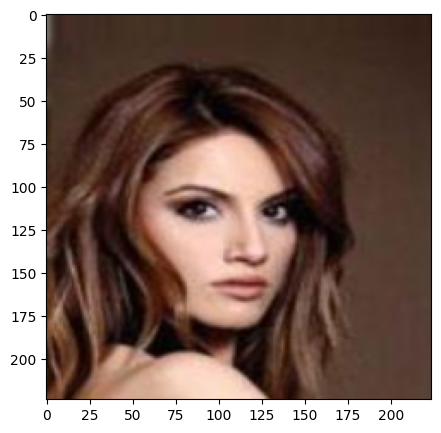

In [ ]:
# Testing the dataset
batch = next(iter(val_dl))
print(batch['images'].shape, batch['labels'].shape)
imgshow(torchvision.utils.make_grid(batch['images'][0]))

In [ ]:
model_pretrained.eval()
with torch.no_grad():
  prod_outputs = model_pretrained(batch['images'][:4].to(device))

AttributeError: 'Tensor' object has no attribute 'hidden_states'

In [ ]:
batch['labels'][:4]

tensor([ 946,   17, 1200, 1197])

In [ ]:
prod_outputs

tensor([[-2.0264, -1.5300, -2.6107,  ..., -3.1700, -3.4884,  0.4853],
        [ 0.9893, -1.3535, -1.3744,  ..., -3.9707, -4.4145, -2.1332],
        [-1.4478,  0.3926,  1.1496,  ..., -3.0401, -2.7123,  0.5069],
        [ 0.5516,  0.3590,  1.3405,  ..., -3.5127, -3.3352, -0.5587]],
       device='cuda:0')

In [ ]:
prod_outputs.argmax(1)

tensor([ 249, 1336,  417, 1044], device='cuda:0')

# Model Testing - TEST Data

In [ ]:
test_ds = dataset_obj.create_dataset(identity_df=combined_small_df[combined_small_df['partition']==2])
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

0it [00:00, ?it/s]

RuntimeError: stack expects a non-empty TensorList

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
# Now we train the model
def testing_function():
    # Initialize accelerator
    accelerator = Accelerator()#(fp16=True)

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    #if accelerator.is_main_process:
    #    datasets.utils.logging.set_verbosity_warning()
    #    transformers.utils.logging.set_verbosity_info()
    #else:
    #    datasets.utils.logging.set_verbosity_error()
    #    transformers.utils.logging.set_verbosity_error()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # Load the model
    model_pretrained = torch.load(hyperparameters['output_dir_pt'])

    # Loss function
    criterion = ContrastiveLoss()

    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    accelerated_model, acclerated_criterion, acclerated_test_dl = accelerator.prepare(model_pretrained, criterion, val_dl)

    # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
    accelerated_model.eval()

    test_labels = []
    test_preds = []

    for batch in tqdm(acclerated_test_dl):

        img1 = batch['pixel_values_1']
        img2 = batch['pixel_values_2']
        label = batch['labels']

        with torch.no_grad():
            emb1 = accelerated_model(img1)
            emb2 = accelerated_model(img2)

        test_loss = acclerated_criterion(emb1, emb2, label)

        test_preds.append(test_loss)
        test_labels.append(label)

        #test_preds = torch.cat(test_pred)
        #test_labels = torch.cat(test_label)
    return test_labels, test_preds


In [ ]:
actual_label, predicted_test_label = testing_function()

<ipython-input-103-f0bc432f2bd1>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_pretrained = torch.load(hyperparameters['output_dir_pt'])


  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
predicted_test_label

[tensor(0.0668, device='cuda:0'),
 tensor(0.0843, device='cuda:0'),
 tensor(0.0377, device='cuda:0'),
 tensor(0.0735, device='cuda:0'),
 tensor(0.0507, device='cuda:0'),
 tensor(0.0502, device='cuda:0'),
 tensor(0.0792, device='cuda:0'),
 tensor(0.0682, device='cuda:0'),
 tensor(0.0630, device='cuda:0'),
 tensor(0.0637, device='cuda:0'),
 tensor(0.0508, device='cuda:0'),
 tensor(0.0810, device='cuda:0'),
 tensor(0.0719, device='cuda:0'),
 tensor(0.0672, device='cuda:0'),
 tensor(0.0818, device='cuda:0'),
 tensor(0.0648, device='cuda:0'),
 tensor(0.0426, device='cuda:0'),
 tensor(0.0333, device='cuda:0'),
 tensor(0.1451, device='cuda:0'),
 tensor(0.1119, device='cuda:0'),
 tensor(0.0560, device='cuda:0'),
 tensor(0.0288, device='cuda:0'),
 tensor(0.0634, device='cuda:0'),
 tensor(0.1121, device='cuda:0'),
 tensor(0.0594, device='cuda:0'),
 tensor(0.0366, device='cuda:0'),
 tensor(0.0507, device='cuda:0'),
 tensor(0.0703, device='cuda:0'),
 tensor(0.0531, device='cuda:0'),
 tensor(0.0293

In [ ]:
actual_labels = torch.cat(actual_label, 0).to('cpu')
predicted_test_labels = torch.cat(predicted_test_label,0).to('cpu')

RuntimeError: zero-dimensional tensor (at position 0) cannot be concatenated

In [ ]:
actual_label

[tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tenso

In [ ]:
len(predicted_test_label)

125

In [ ]:
predicted_test_label.numpy()

AttributeError: 'list' object has no attribute 'numpy'

In [ ]:
len(actual_labels)

1000

In [ ]:
print(classification_report(actual_labels.numpy(),
                            predicted_test_labels.numpy(),
                            ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      0.75      0.86         4
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      0.50      0.67         4
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         3
          11       0.50      1.00      0.67         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         3
          15       0.67      1.00      0.80         4
          16       0.20      0.33      0.25         3
          17       1.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
